# Юнит-экономика Procrastinate Pro+


Проведен анализ данных от ProcrastinatePRO+.
Рассчитаны различные метрики, использован когортный анализ: LTV, CAC, Retention rate, DAU, WAU, MAU и т.д. Использованы уже написанные ранее функции расчёта метрик. Сделаны правильные выводы по полученным данным.

##  Предобработка данных
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный. Путь к файлам:

 -   /datasets/visits_info_short.csv. 
 -   /datasets/orders_info_short.csv. 
 -   /datasets/costs_info_short.csv.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
#настройка вывода дробный чисел. 
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
purchases = pd.read_csv('/datasets/orders_info_short.csv')
ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
events = None

In [3]:
#создадим функцию для описания датафреймов
def info_data(data_frame):
    print('Информация о колонках\n')
    print( data_frame.info() )
    
    print('\nПервые 5 строк')
    display(data_frame.head())
    
    print('\nКоличество дубликатов в колонках')
    display(data_frame.duplicated().sum())
    
    return

In [4]:
def inspect(df):
    display(df.head()) 
    df.info() 
    print ('Количество дубликатов -', df.duplicated().sum())
    numeric_columns=df.describe().columns
    display(df.describe())
    display()
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    for column_name in df.columns:
        if column_name not in numeric_columns:
            if 'session' in column_name or 'dt' in column_name:
                df[column_name] = pd.to_datetime(df[column_name])
            else:
                display(df[column_name].value_counts())
                print(50*'*')
    return df
visits = inspect(visits)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
Количество дубликатов - 0


,User Id
count,309901.00
mean,499766449382.70
std,288789916887.83
min,599326.00
25%,249369122776.00
50%,498990589687.00
75%,749521111616.00
max,999999563947.00


33606575057     46
943775408561    36
901180916748    35
870784569391    34
764086596354    33
                ..
350468480225     1
748123264144     1
909267360937     1
816252757222     1
425788122907     1
Name: user_id, Length: 150008, dtype: int64

**************************************************


United States    207327
UK                36419
France            35396
Germany           30759
Name: region, dtype: int64

**************************************************


iPhone     112603
Android     72590
PC          62686
Mac         62022
Name: device, dtype: int64

**************************************************


organic               107760
TipTop                 54794
FaceBoom               49022
WahooNetBanner         20465
LeapBob                17013
OppleCreativeMedia     16794
RocketSuperAds         12724
YRabbit                 9053
MediaTornado            8878
AdNonSense              6891
lambdaMediaAds          6507
Name: channel, dtype: int64

**************************************************


In [5]:
info_data(visits)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
None

Первые 5 строк


,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40



Количество дубликатов в колонках


0

In [6]:
#применяем к названию столбцов "змеиный" регистр:
#visits= (
    #visits.rename(columns={'User Id':'user_id', 'Region':'region', 'Device':'device', 'Channel':'channel', 'Session Start':'session_start', 'Session End':'session_end'})
#)

In [7]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]

In [8]:
visits

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


In [9]:
#Приведем к типу даты столбцы session_start и session_end к типу даты:
visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])

In [10]:
info_data(purchases)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
None

Первые 5 строк


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99



Количество дубликатов в колонках


0

In [11]:
#изменим наименования столбцов:
purchases= (
    purchases.rename(columns={'User Id':'user_id', 'Event Dt':'event_dt', 'Revenue':'revenue'})
)

In [12]:
#и приведем к формату datetime столбец event_dt:
purchases['event_dt']=pd.to_datetime(purchases['event_dt'])

In [13]:
info_data(ad_costs)

Информация о колонках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None

Первые 5 строк


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10



Количество дубликатов в колонках


0

In [14]:
ad_costs=ad_costs.rename(columns={'Channel':'channel'})

In [15]:
ad_costs['dt']=pd.to_datetime(ad_costs['dt']).dt.date

## Функции для расчета и анализа LTV, ROI, удержания и конверсии и построения соответствующих графиков

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

### Функция get_profiles

In [16]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

### Функция get_ltv

In [17]:
#задаем функцию для расчета LTV и ROI:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функция plot_ltv_roi

In [18]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Функция get_retention

In [20]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция get_conversion

In [21]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

### Функция plot_retention

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Функция plot_conversion

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(20, 10))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

##  Исследовательский анализ данных

Постройте профили пользователей. Определите минимальную и максимальную дату привлечения пользователей.

Выясните:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### Построение пользовательских профилей

In [24]:
events=None
profiles = get_profiles(visits, purchases, events, ad_costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


**Определим минимальную и максимальную дату привлечения пользователей:**

In [25]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
min_date, max_date

(datetime.date(2019, 5, 1), datetime.date(2019, 10, 27))

**Посмотрим, в каких странах больше всего платящих пользователей:**

In [26]:
profiles.groupby('region').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,0.07
Germany,14981,0.04
UK,17575,0.04
France,17450,0.04


**Посмотрим, с каких устройств чаще всего делают заказы:**

In [27]:
profiles.groupby('device').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,0.06
iPhone,54479,0.06
Android,35032,0.06
PC,30455,0.05


**По аналогии определим, сколько платящих пользователей привлек каждый из каналов:**

In [28]:
profiles.groupby('channel').agg({'user_id':'nunique', 'payer':'mean'}).sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
FaceBoom,29144,0.12
AdNonSense,3880,0.11
lambdaMediaAds,2149,0.10
TipTop,19561,0.10
RocketSuperAds,4448,0.08
WahooNetBanner,8553,0.05
YRabbit,4312,0.04
MediaTornado,4364,0.04
LeapBob,8553,0.03


**Дополнительно посмотрим, какими устройствами чаще всего пользуются в разных странах:**

In [29]:
profiles_pivot = profiles.pivot_table(index='region', columns = 'device', values = 'user_id', aggfunc = 'nunique')
profiles_pivot

device,Android,Mac,PC,iPhone
region,,,,
France,5252,1838,6940,3420
Germany,4440,1584,5945,3012
UK,5141,1778,7138,3518
United States,20199,24842,10432,44529


### Вывод:

- из 4 стран, пользователи которых используют приложение, с огромным отрывом по доле платящих пользователей лидирует США;
- Больше всего покупок в приложении совершается посредством Mac и iPhone;
- Лучше всего конвертируются в платящих пользователи, привлеченные с посредством Faceboom,AdNonSense,lambdaMediaAds, TipTop. Остальные каналы заметно отстают. Очень слабая конверсия органических пользователей при колоссально высоких цифрах количества пользователей(с этим надо что-то делать, возможно, у приложения непонятный интерфейс, или без рекламы непонятна главная цель его использования).

##  Маркетинг

Выясните:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

Функция **get_profiles** создала столбец со значением стоимости привлечения для каждого пользователя. Посмотрим, какова суммарная стоимость привлечения всех пользователей:


In [30]:
profiles['acquisition_cost'].sum().round(2)

105497.3

Общая стоимость затреченных на рекламу средств - примерно 105,5 тысяч у.е.

In [31]:
profiles.groupby('channel').agg({'user_id':'nunique', 'acquisition_cost':'sum'}).sort_values(by='acquisition_cost', ascending=False)


,user_id,acquisition_cost
channel,,
TipTop,19561,54751.30
FaceBoom,29144,32445.60
WahooNetBanner,8553,5151.00
AdNonSense,3880,3911.25
OppleCreativeMedia,8605,2151.25
RocketSuperAds,4448,1833.00
LeapBob,8553,1797.60
lambdaMediaAds,2149,1557.60
MediaTornado,4364,954.48


Подавляющее количество пользователей привлечены с FaceBoom и TipTop, причем Faceboom является рекордсменом среди каналов по доле пользователей, которые совершили покупку. А TipTop, самый дорогой канал привлечения, только на 4 месте в рейтинге заплативших.
Так как органические пользователи не стоили ничего в плане рекламных затрат, для визуализации дикамики отфильтруем их:

In [32]:
profiles_query=profiles.query('channel != "organic"')

### Cредний CAC на одного пользователя для всего проекта:

In [33]:
profiles_query['acquisition_cost'].mean().round(2)

1.13

### Cредний CAC для каждого источника трафика:

In [34]:
profiles_query.groupby('channel').agg({'acquisition_cost':'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


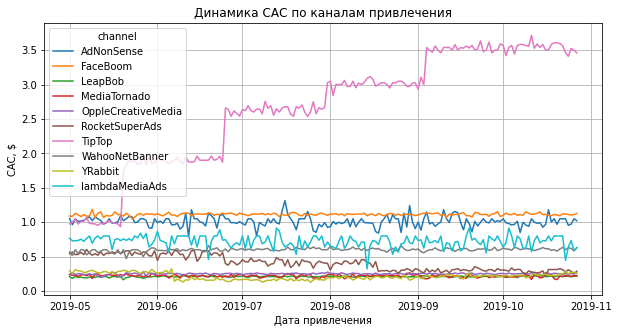

In [35]:
profiles_query.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

### Вывод:

Все каналы, за исключением TipTop демонстрируют стабильную среднюю стоимость привлечения клиентов в промежутке 0,25 - 1,1 у.е. Пока рано делать об этом выводы, такие скачки могут быть связаны с увеличением стоимости размещения рекламных баннеров на площадке или уменьшением количества привлекаемых клиентов от месяца к месяцу при неизменной стоимости, хотя я больше пока склоняюсь к 1 варианту, так как кривая меняется скачкообразно в начале каждого месяца.

## Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

Вызовем функцию get_ltv, которая рассчитывает LTV и ROI, но сначала определим момент и горизонт анализа.

In [36]:
observation_date=datetime(2019, 11, 1).date()
horizon_days=14

### Анализ общей окупаемости рекламы

In [37]:
ltv_raw, ltv, ltv_history, roi, roi_history  = get_ltv(profiles_query, purchases, observation_date, horizon_days)

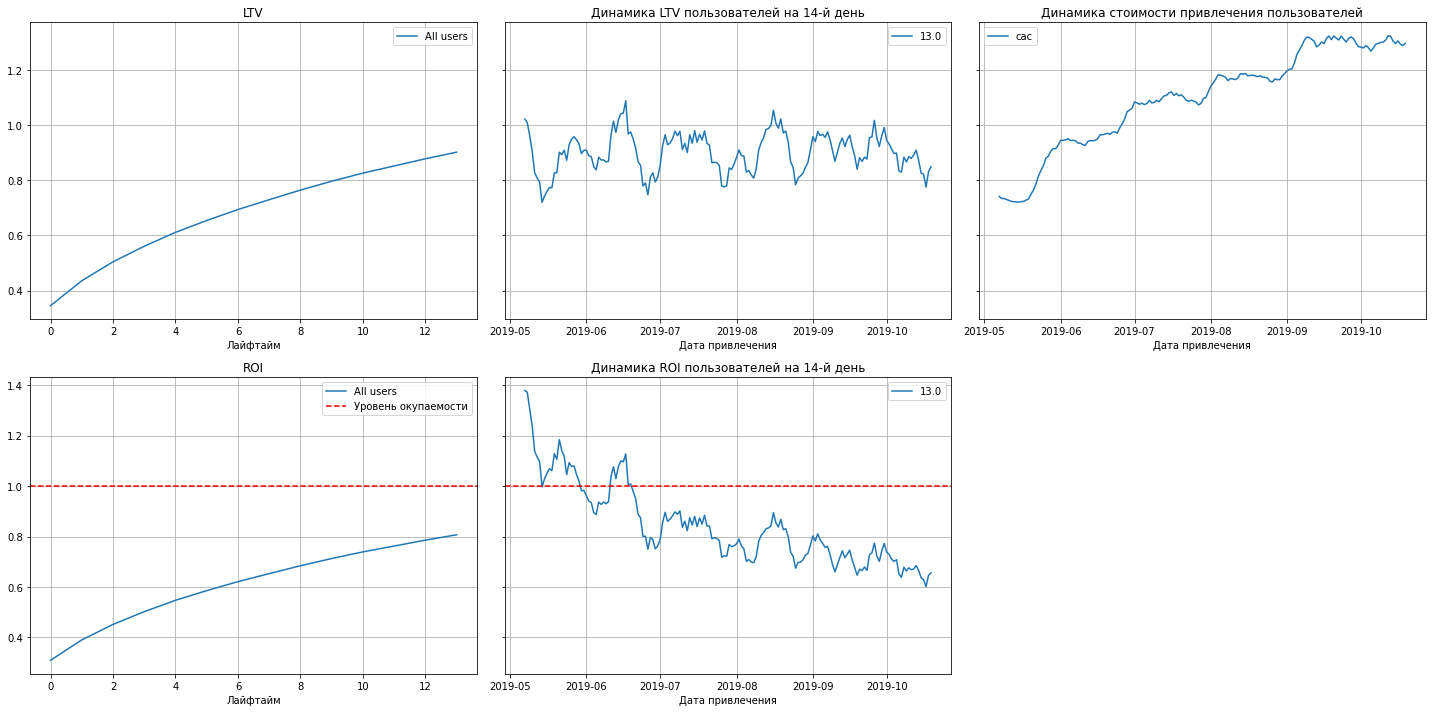

In [38]:
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=7)

- СAC неуклонно растет, что говорит о возрастающем рекламном бюджете;
- Реклама не окупилась, кривая не пересекла уровень окупаемости;
- Среднее значение ROI на уровне 0.7, что говорит о том, что дела у бизнеса идут очень плохо.
- Динамика ROI ухудшается;
- Кривая LTV близка к эталону, следователельно, дело не в качестве пользователей;
 

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

Чтобы проанализировать окупаемость рекламы в разбивке по каналам привлечения пользователей, передадим функции get_ltv данные с доп параметром dimensions:

In [39]:
ltv_raw_channel, ltv_channel, ltv_history_channel, roi_channel, roi_history_channel  = get_ltv(profiles_query, purchases, observation_date, horizon_days, dimensions=['channel'])

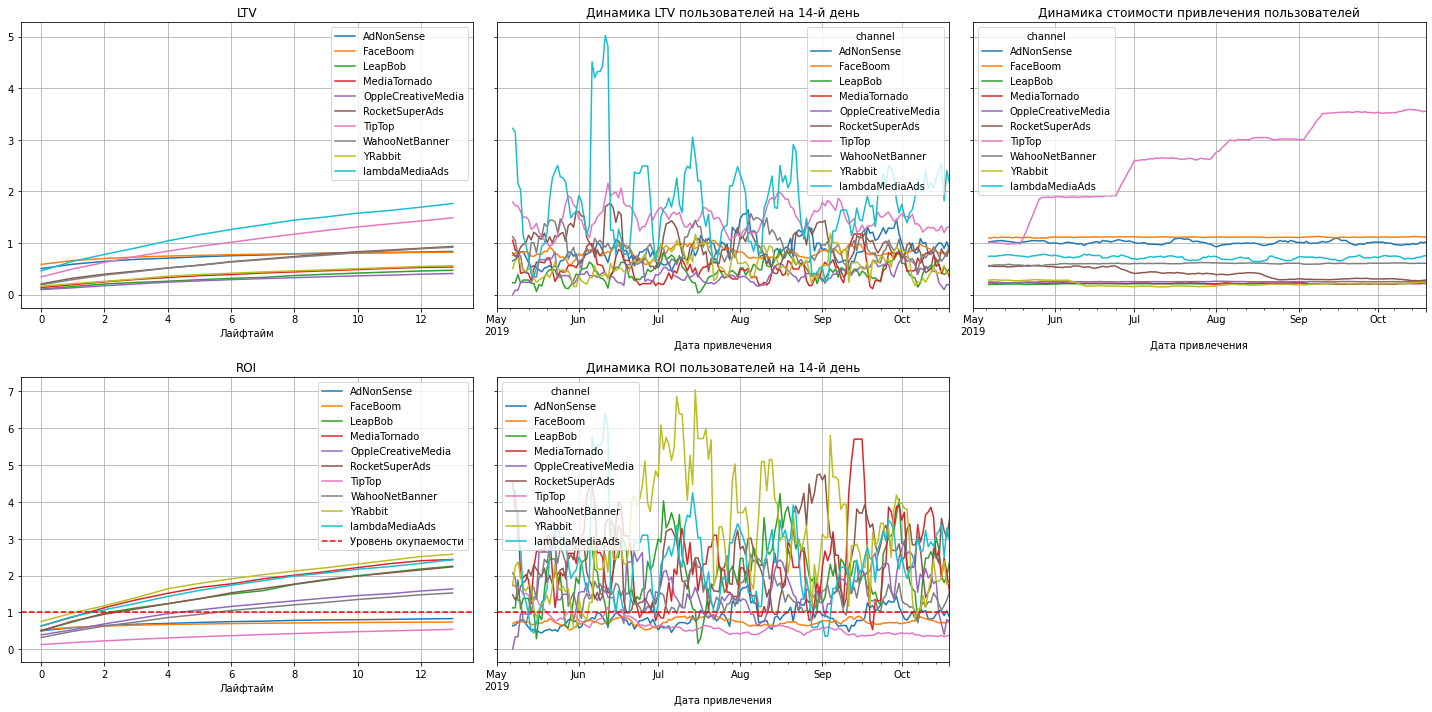

In [40]:
plot_ltv_roi(ltv_channel, ltv_history_channel, roi_channel, roi_history_channel, horizon_days, window=7)

- выше всех LTV у пользователей, пришедших от канала lambdaMediaAds, чуть ниже - у TipTop. Они же выше всех по динамике;
- САС у TipTop крайне подозрительно увеличивается, а ROI ниже всех!
- ROI также ниже уровня окупаемости у FaceBoom и AdNonSense.

**Перейдем к изучению конверсии и удержания по рекламным каналам:**

**Удержание**

In [41]:
retention_raw_channel, retention_channel, retention_history_channel = get_retention(profiles_query, visits, observation_date, horizon_days, dimensions=['channel'])

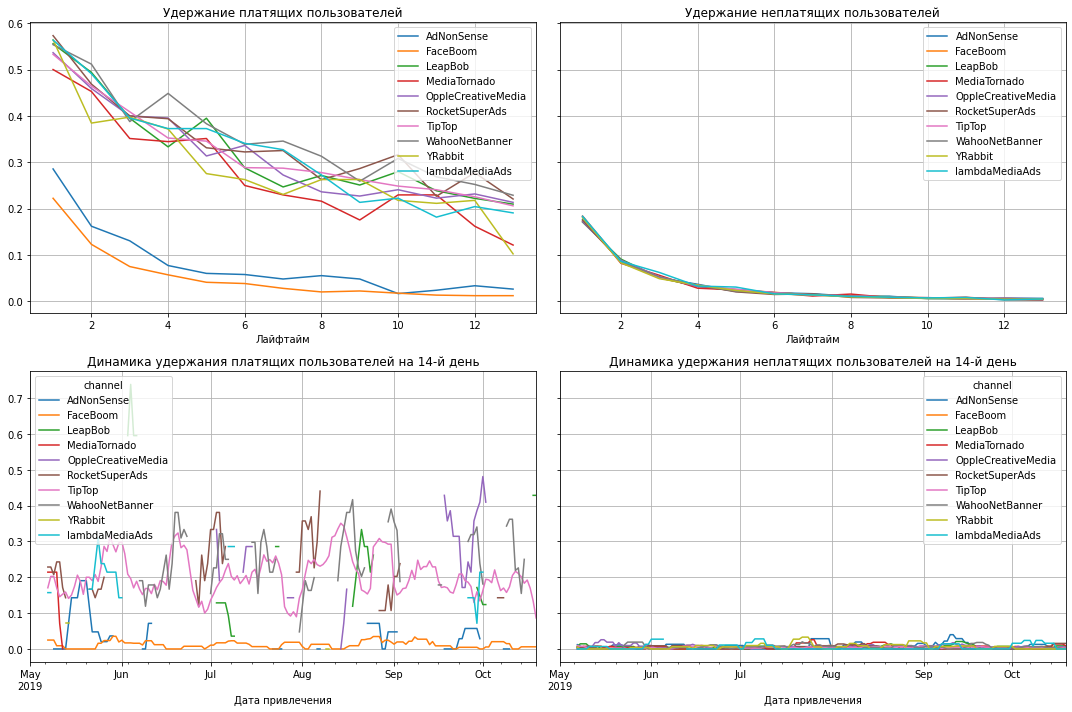

In [42]:
plot_retention(retention_channel, retention_history_channel, horizon_days)

У привлеченных платящих пользователей с FaceBoom динами ка удержания очень близка к прямой линии. Критически низкий показатель при учете стоимости размещения рекламы. Пользователи совершают 1 покупку и перестают пользоваться приложением.

**Конверсия:**

In [43]:
conversation_raw_channel, conversation_channel, conversation_history_channel= get_conversion(profiles_query, purchases, observation_date, horizon_days, dimensions=['channel'])

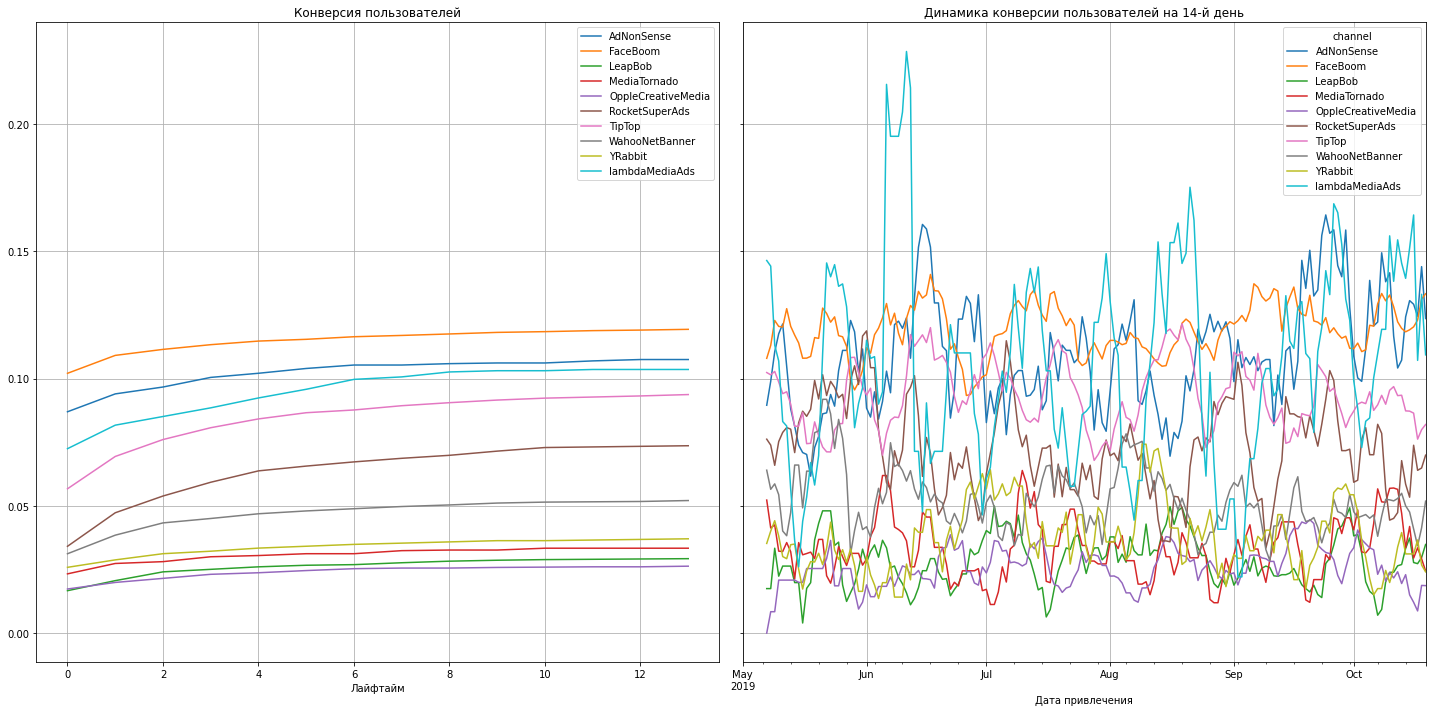

In [44]:
plot_conversion(conversation_channel, conversation_history_channel, horizon_days)

Кривая конверсии слабо растет. 

### Анализ окупаемости рекламы с разбивкой по странам

In [45]:
ltv_raw_region, ltv_region, ltv_history_region, roi_region, roi_history_region  = get_ltv(profiles_query, purchases, observation_date, horizon_days, dimensions=['region'])

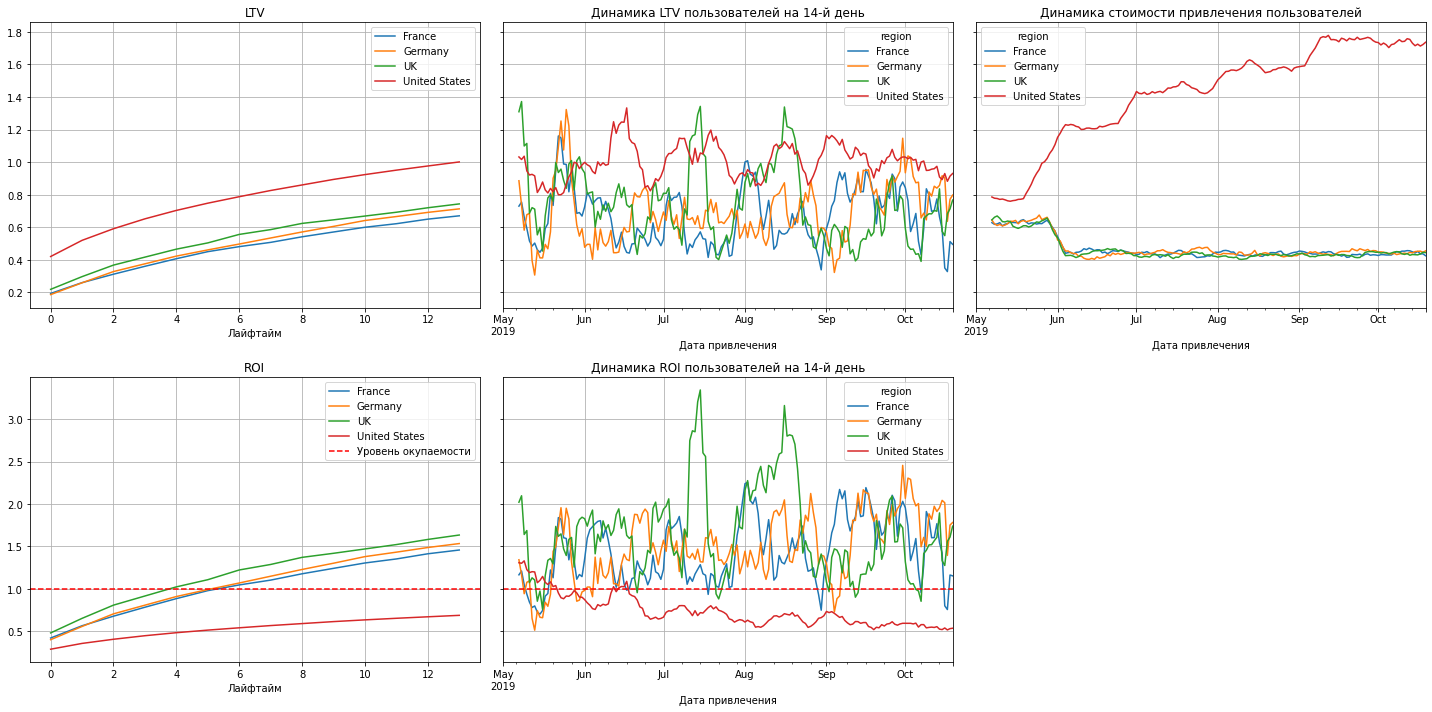

In [46]:
plot_ltv_roi(ltv_region, ltv_history_region, roi_region, roi_history_region, horizon_days, window=7)

Источник проблемы замечен: при нормальном LTV в США очень низкий ROI, что означает высокий САС (и график динамики САС это подтверждает).
Кривая динамики САС по США очень напоминает кривую динамики канала TipTop.

**Теперь посмотрим на графики конверсии и удержания в разрезе стран:**

**Удержание по странам**

In [47]:

retention_raw_region, retention_region, retention_history_region = get_retention(profiles_query, visits, observation_date, horizon_days, dimensions=['region'])

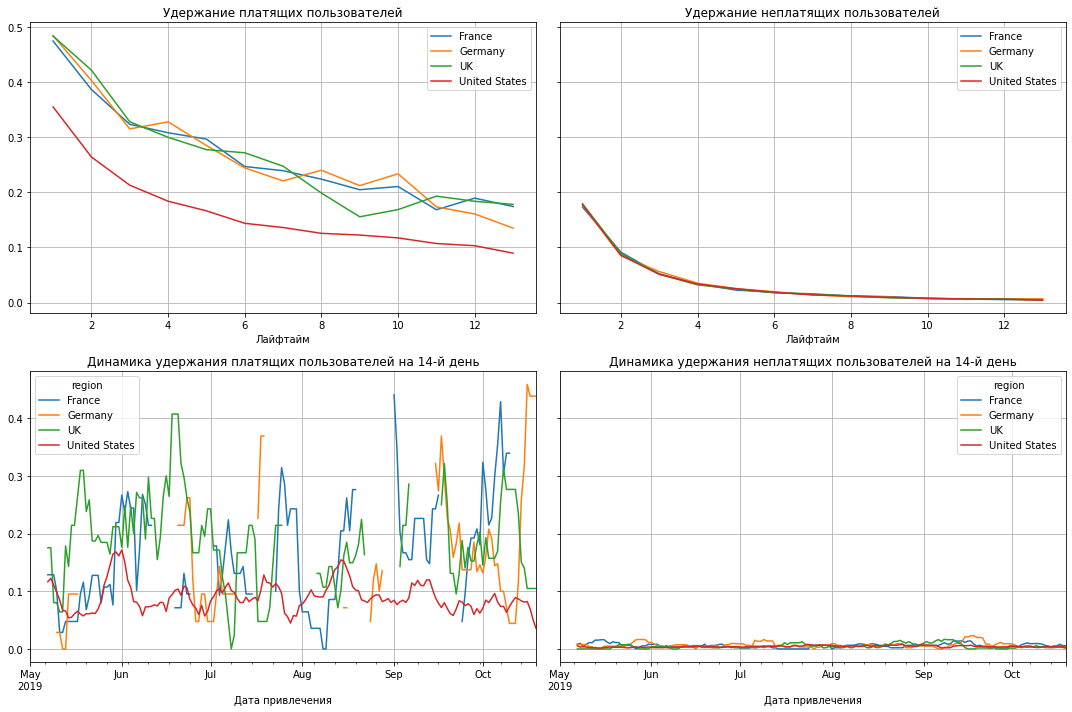

In [48]:
plot_retention(retention_region, retention_history_region, horizon_days)

Удержание 14 дня ниже всех для платящих пользователей из США ниже всех.

**Конверсия по странам**

In [49]:
conversation_raw_region, conversation_region, conversation_history_region= get_conversion(profiles_query, purchases, observation_date, horizon_days, dimensions=['region'])

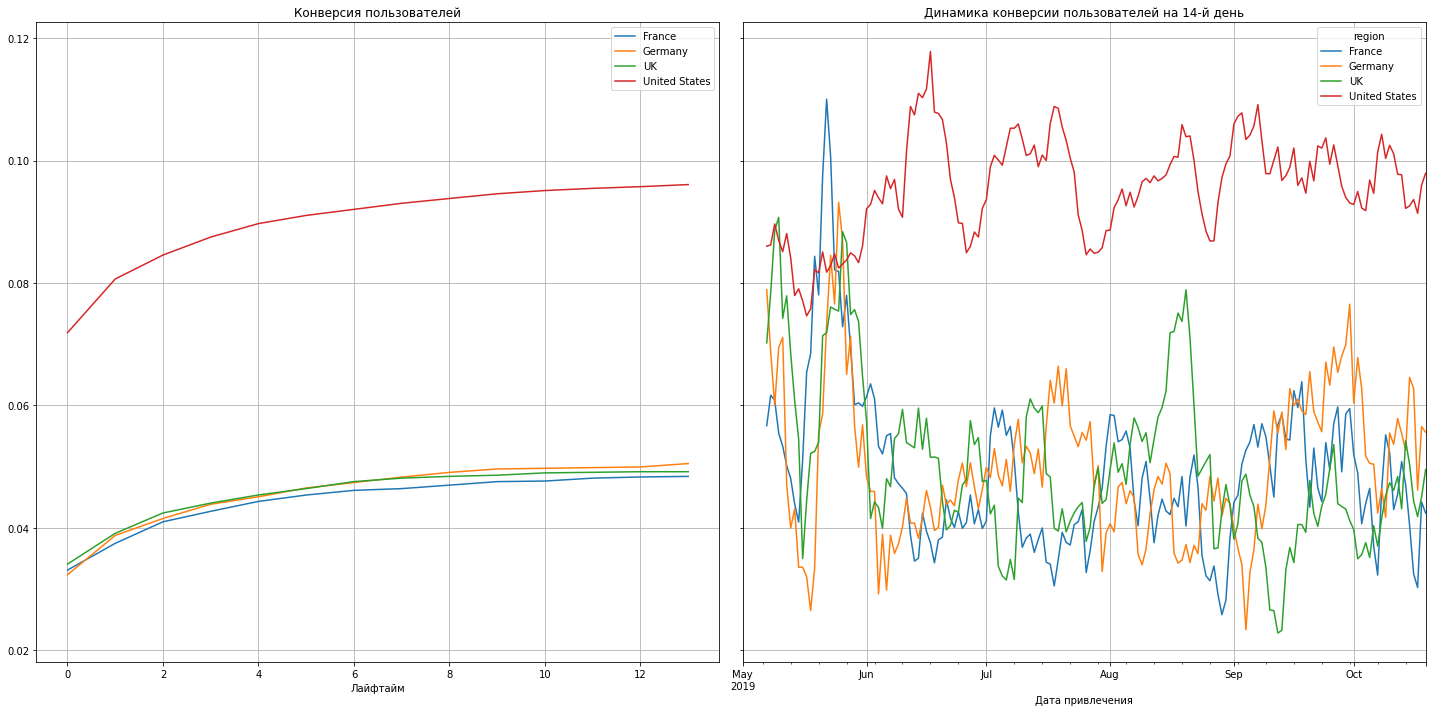

In [50]:
plot_conversion(conversation_region, conversation_history_region, horizon_days)

Пользователи, привлеченные в США, лучше всех конвертируются в платящих!Это самый перспективный для приложения рынок."Европейские" пользователи приблизительно одинаково, но на порядок хуже.

Посмотрим на метрики в разрезе только американского рынка:

In [51]:
profiles_query_usa = profiles_query.query('region=="United States"')

In [52]:
ltv_raw_region_usa, ltv_region_usa, ltv_history_region_usa, roi_region_usa, roi_history_region_usa  = get_ltv(profiles_query_usa, purchases, observation_date, horizon_days)

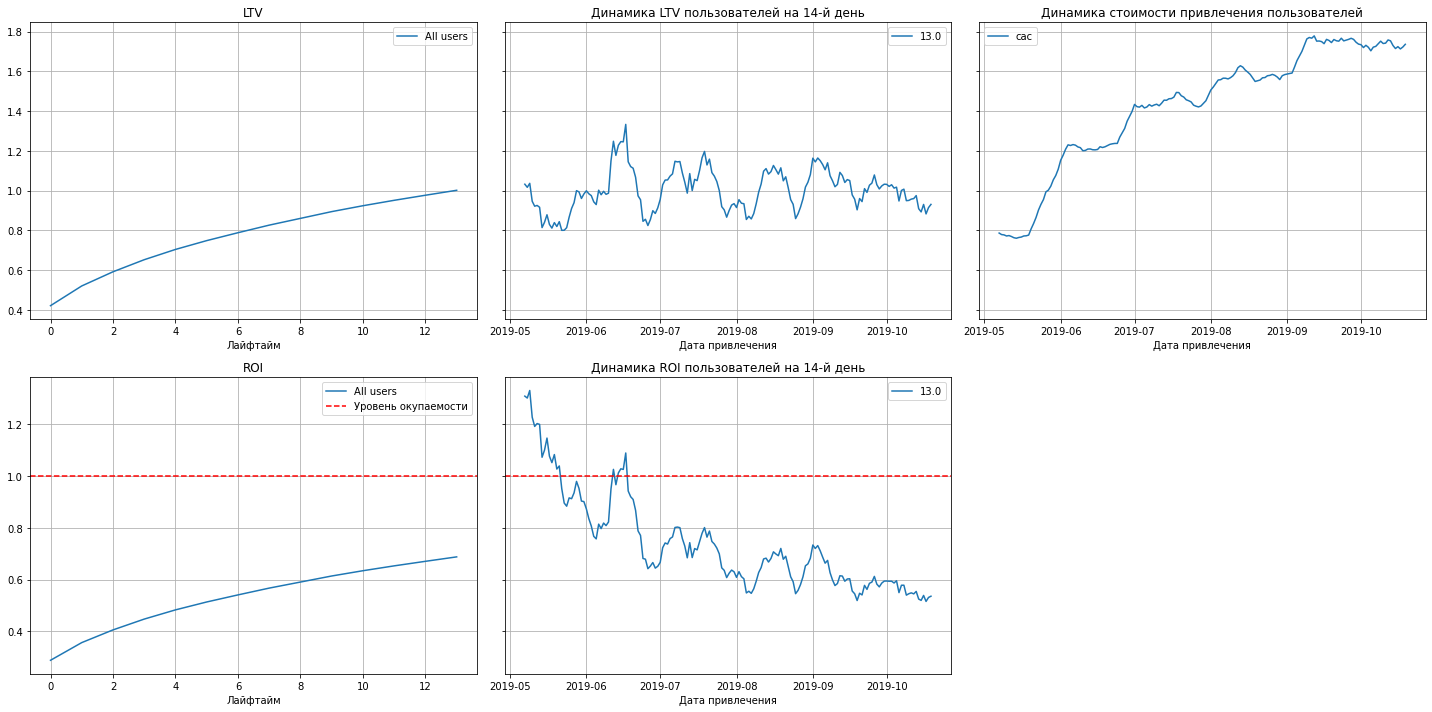

In [53]:
plot_ltv_roi(ltv_region_usa, ltv_history_region_usa, roi_region_usa, roi_history_region_usa, horizon_days, window=7)

Если повысить окупаемость пользователей в США, бизнес от этого выиграет. Большая проблема- это общая дороговизна рекламы.

In [54]:
ltv_raw_region_usa, ltv_region_usa, ltv_history_region_usa, roi_region_usa, roi_history_region_usa  = get_ltv(profiles_query_usa, purchases, observation_date, horizon_days, dimensions=['channel'])

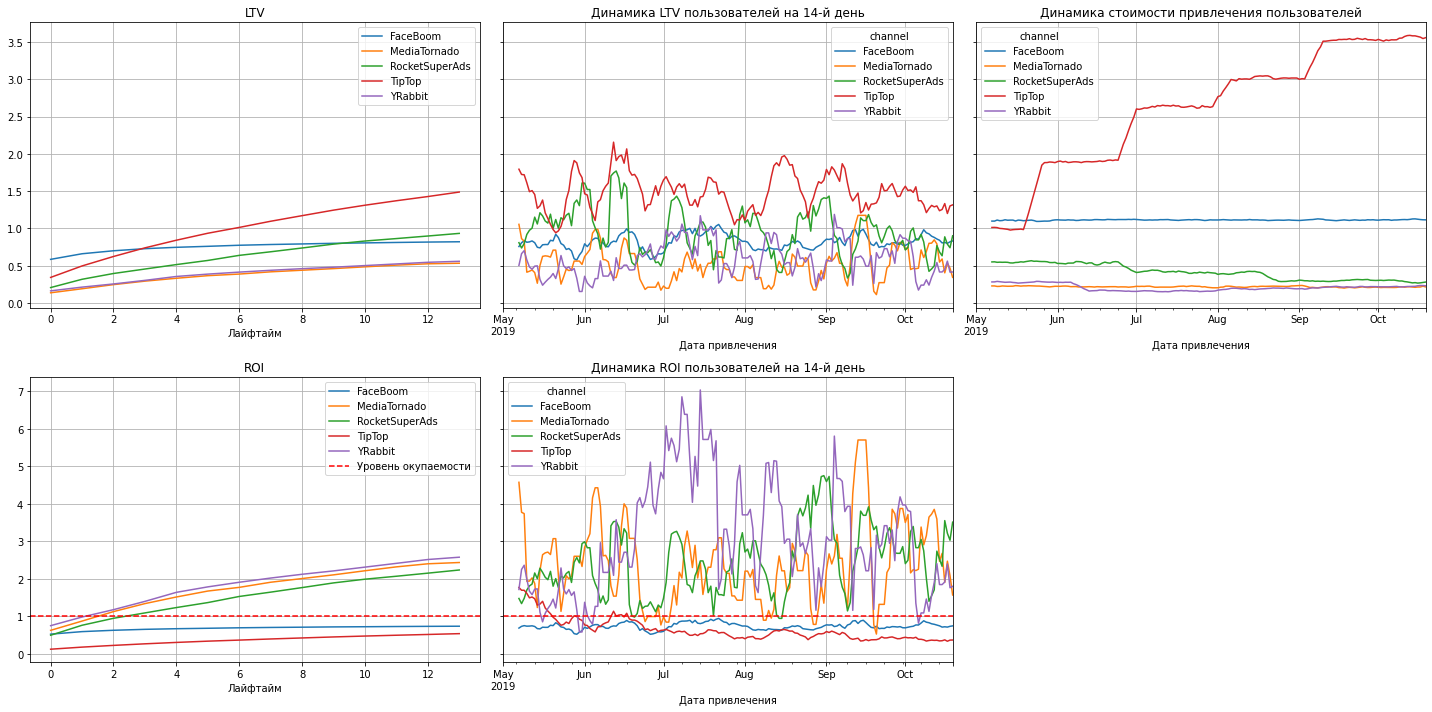

In [55]:
plot_ltv_roi(ltv_region_usa, ltv_history_region_usa, roi_region_usa, roi_history_region_usa, horizon_days, window=7)

### Анализ окупаемости рекламы с разбивкой по устройствам

**Сначала посмотрим на метрики CAC, LTV, ROI:**

In [56]:
ltv_raw_device, ltv_device, ltv_history_device, roi_device, roi_history_device  = get_ltv(profiles_query, purchases, observation_date, horizon_days, dimensions=['device'])

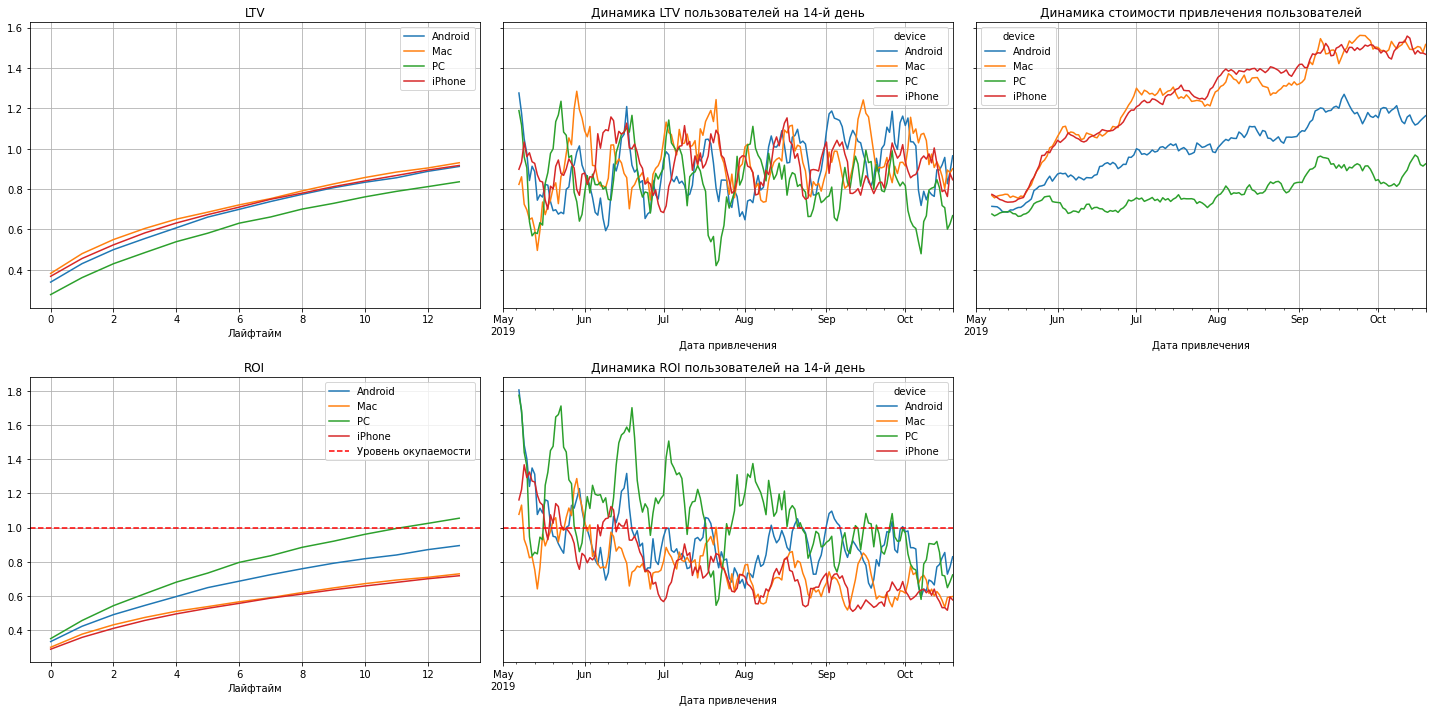

In [57]:
plot_ltv_roi(ltv_device, ltv_history_device, roi_device, roi_history_device, horizon_days, window=7)

В результате хорошую окупаемость показывают только пользователи ПК, но эти пользователи не очень "ценны" (нужно посмотреть конверсию). Пользователи операционок iOS очень дороги в привлечении и не окупаются. Есть предположение, что удобнее всего работать в веб-версии приложения. 

**Удержание:**

In [58]:
retention_raw_device, retention_device, retention_history_device = get_retention(profiles_query, visits, observation_date, horizon_days, dimensions=['device'])

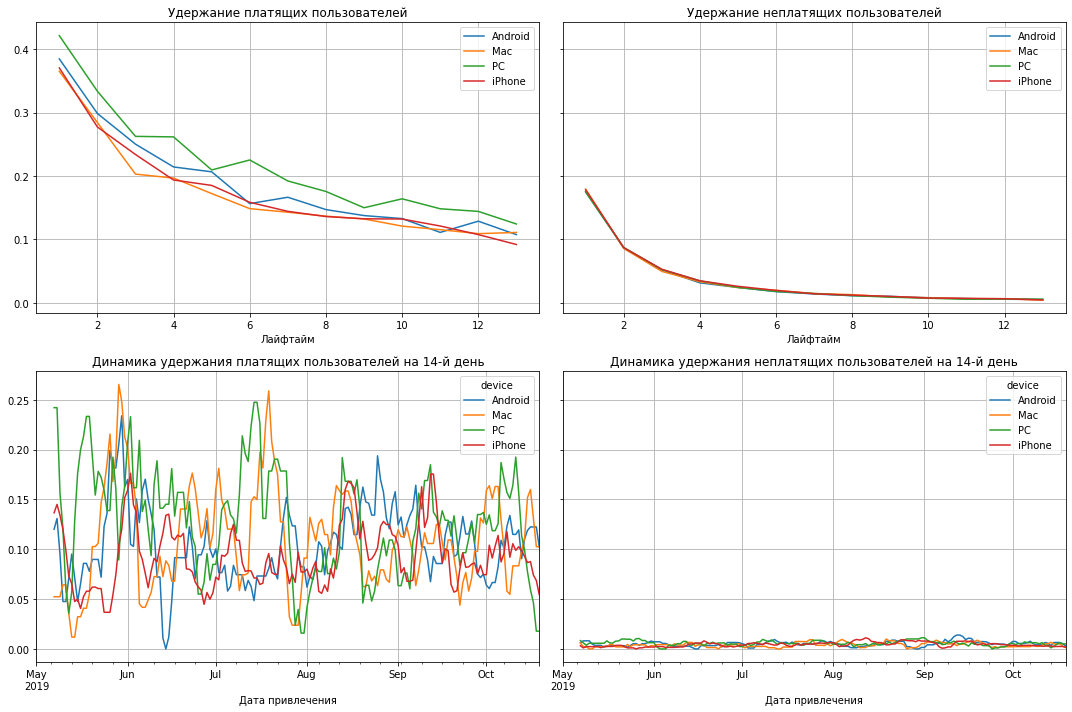

In [59]:
plot_retention(retention_device, retention_history_device, horizon_days)

Платящие пользователи лучше удерживаются с Mac и PC, чем с мобильных устройств. 

**Конверсия:**

In [60]:
conversation_raw_device, conversation_device, conversation_history_device= get_conversion(profiles_query, purchases, observation_date, horizon_days, dimensions=['device'])

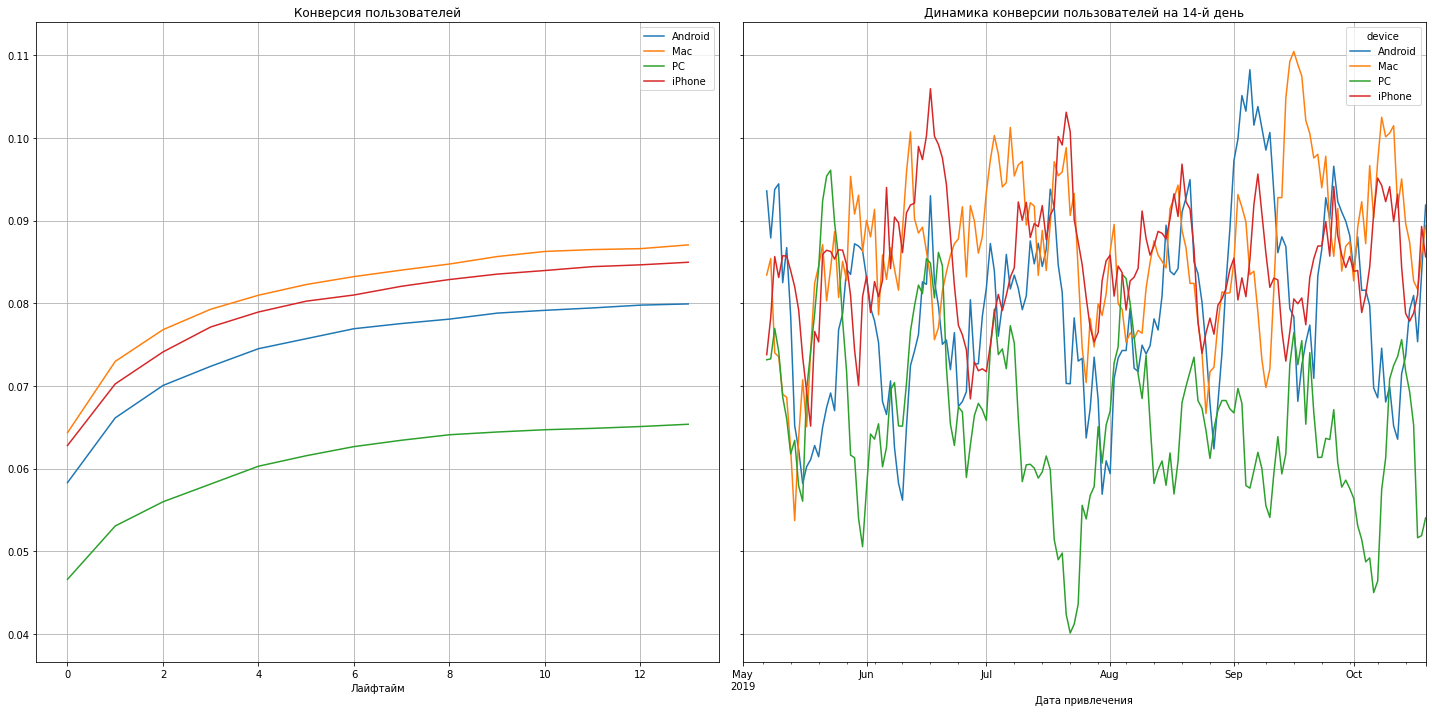

In [61]:
plot_conversion(conversation_device, conversation_history_device, horizon_days)

Да, пользователи ПК значительно менее качественные. Рекламную компанию нужно ориентировать на пользователей iOS. Android тоже показывает неплохой результат в динамике.

## Общие выводы и рекомендации
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

Оздоровить метрики Procrastination Pro могут следующие методы:
- Реклама не окупается.поиск альтернативных каналов рекламы с целью снизить расходы на привлечение. Самый убыточный рекламный канал -  TipTop. Возможо, аудитория данного канала не подходит по своей специфике.
- При том, что пользователи стабильно конвертируются в платящих, динамика ROI показывает, что пользователи платят только на ранних этапах взаимодействия с приложением. Далее коэффициент падает. Стоит повысить привлекательность 2 и последующей покупок в приложении;
- в США огромное количество пользователей предпочитает Mac и iPhone. Можно провести эксперименты по качеству работы приложения на устройствах с операционной системой iOS.
- Рынок США самый многочисленный и перспективный, маркетинговые стратегии должны строиться с учетом его запросов.